_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment. 

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`). 

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [190]:
# YOUR CODE HERE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder, OrdinalEncoder
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [230]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'

# YOUR CODE HERE
df = pd.read_csv(url,
                 parse_dates=['Inspection Date'],
                 index_col='Inspection Date').sort_index()

In [231]:
print(df.shape, "\n")
df.head()

(51916, 17) 



,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Location,Fail,Serious Violations Found
Inspection Date,,,,,,,,,,,,,,,,,
2010-01-04,70269,mr.daniel's,mr.daniel's,1899292.0,Restaurant,Risk 1 (High),5645 W BELMONT AVE,CHICAGO,IL,60634.0,License Re-Inspection,NaN,41.938443,-87.768318,"{'longitude': '-87.76831838068422', 'latitude'...",0,NaN
2010-01-04,67732,WOLCOTT'S,TROQUET,1992039.0,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,CHICAGO,IL,60613.0,License Re-Inspection,NaN,41.961606,-87.675967,"{'longitude': '-87.67596676683779', 'latitude'...",0,NaN
2010-01-05,96246,THE LEARNING TREE II,THE LEARNING TREE II,1869843.0,Daycare Above and Under 2 Years,Risk 1 (High),8233 S PULASKI RD,CHICAGO,IL,60652.0,License,NaN,41.742993,-87.721558,"{'longitude': '-87.72155821260196', 'latitude'...",0,NaN
2010-01-05,70273,THE GREAT AMERICAN BAGEL,THE GREAT AMERICAN BAGEL (T3-H10),1879164.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,Canvass,"9. WATER SOURCE: SAFE, HOT & COLD UNDER CITY P...",42.008536,-87.914428,"{'longitude': '-87.91442843927047', 'latitude'...",1,0.0
2010-01-05,67758,SU TAQUERIA EL GALLO BRAVO #4,SU TAQUERIA EL GALLO BRAVO #4,1766968.0,Restaurant,Risk 1 (High),5650 W GRAND AVE,CHICAGO,IL,60639.0,Complaint,19. OUTSIDE GARBAGE WASTE GREASE AND STORAGE A...,41.919224,-87.767734,"{'longitude': '-87.76773430251839', 'latitude'...",1,0.0


**Task 1 Test**

In [232]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [233]:
inspect = df[['Violations', 'Fail', 'Serious Violations Found']]
inspect

,Violations,Fail,Serious Violations Found
Inspection Date,,,
2010-01-04,NaN,0,NaN
2010-01-04,NaN,0,NaN
2010-01-05,NaN,0,NaN
2010-01-05,"9. WATER SOURCE: SAFE, HOT & COLD UNDER CITY P...",1,0.0
2010-01-05,19. OUTSIDE GARBAGE WASTE GREASE AND STORAGE A...,1,0.0
...,...,...,...
2019-03-19,NaN,0,NaN
2019-03-19,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",1,0.0
2019-03-20,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,1,0.0


In [234]:
inspect['Serious Violations Found'].value_counts()

0.0    34508
1.0     4786
2.0     2148
3.0      627
4.0      155
5.0       19
6.0        9
8.0        5
7.0        4
Name: Serious Violations Found, dtype: int64

In [235]:
'''T2. Identify data leakage column.'''

# df.rename(columns={'Fail': 'leaky_col'}, inplace=True)
# df.head()

leaky_col = 'Serious Violations Found'

**Task 2 Test**

In [236]:
'''T2 Test'''
# This is a hidden test. 
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51916 entries, 2010-01-04 to 2019-03-20
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Inspection ID             51916 non-null  int64  
 1   DBA Name                  51916 non-null  object 
 2   AKA Name                  51293 non-null  object 
 3   License #                 51911 non-null  float64
 4   Facility Type             51692 non-null  object 
 5   Risk                      51904 non-null  object 
 6   Address                   51916 non-null  object 
 7   City                      51863 non-null  object 
 8   State                     51906 non-null  object 
 9   Zip                       51890 non-null  float64
 10  Inspection Type           51915 non-null  object 
 11  Violations                42261 non-null  object 
 12  Latitude                  51718 non-null  float64
 13  Longitude                 51718 non-null  fl

In [238]:
# State should be removed 

cat_cols = df.select_dtypes('object').columns
for col in cat_cols:
    print(f'{col}', df[col].nunique())

DBA Name 17049
AKA Name 16350
Facility Type 329
Risk 3
Address 13954
City 39
State 1
Inspection Type 51
Violations 42164
Location 13410


In [239]:
df.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Type',
       'Violations', 'Latitude', 'Longitude', 'Location', 'Fail',
       'Serious Violations Found'],
      dtype='object')

In [240]:
print(df['Zip'].nunique())

86


In [241]:
df.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Type',
       'Violations', 'Latitude', 'Longitude', 'Location', 'Fail',
       'Serious Violations Found'],
      dtype='object')

In [242]:
col_names = []
for col in list(df.columns):
    col_names.append(col.strip().lower().replace(' ', '_'))

col_names    

['inspection_id',
 'dba_name',
 'aka_name',
 'license_#',
 'facility_type',
 'risk',
 'address',
 'city',
 'state',
 'zip',
 'inspection_type',
 'violations',
 'latitude',
 'longitude',
 'location',
 'fail',
 'serious_violations_found']

In [243]:
df.select_dtypes('object').nunique()

DBA Name           17049
AKA Name           16350
Facility Type        329
Risk                   3
Address            13954
City                  39
State                  1
Inspection Type       51
Violations         42164
Location           13410
dtype: int64

In [244]:
'''T3. Write wrangle function.'''
def wrangle(df):
    # 1. Drop the 'leaky' column
    df.drop(columns=leaky_col, inplace=True)
    
    # 2. Remove high-cardinality categorical columns (> 500 categories)
    high_card_cols = [col for col in df.select_dtypes('object').columns 
                      if df[col].nunique() > 500]
    
    df.drop(high_card_cols, axis=1, inplace=True)
    
    # 3. Remove categorical columns that have only one category
    single = [col for col in df.select_dtypes('object').columns 
                      if df[col].nunique() == 1]
    
    df.drop(single, axis=1, inplace=True)
    
    # 4. Removes numerical columns that are unique identifiers for each observation
    df.drop(columns=['Inspection ID', 'License #'], inplace=True)
    
    return df

df = wrangle(df)

In [245]:
df.head()

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude,Fail
Inspection Date,,,,,,,,
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60634.0,License Re-Inspection,41.938443,-87.768318,0
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60613.0,License Re-Inspection,41.961606,-87.675967,0
2010-01-05,Daycare Above and Under 2 Years,Risk 1 (High),CHICAGO,60652.0,License,41.742993,-87.721558,0
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60666.0,Canvass,42.008536,-87.914428,1
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60639.0,Complaint,41.919224,-87.767734,1


**Task 3 Test**

In [246]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [247]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'

y = df[target]
X = df.drop(columns=target)

In [248]:
print(y.shape, X.shape)

(51916,) (51916, 7)


**Task 4 Test**

In [249]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [250]:
'''T5. Split dataset into training and validation sets.'''

cutoff = X.index.year < 2017

X_train, y_train = X[cutoff], y[cutoff]
X_val, y_val = X[~cutoff], y[~cutoff]

In [251]:
X_train.tail()

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude
Inspection Date,,,,,,,
2016-12-30,Grocery Store,Risk 3 (Low),CHICAGO,60630.0,Canvass,41.963710,-87.728052
2016-12-30,Restaurant,Risk 2 (Medium),CHICAGO,60614.0,License,41.925235,-87.669233
2016-12-30,Restaurant,Risk 2 (Medium),CHICAGO,60607.0,License,41.881627,-87.649752
2016-12-30,Restaurant,Risk 1 (High),CHICAGO,60618.0,Canvass,41.942917,-87.720107
2016-12-30,Grocery Store,Risk 2 (Medium),CHICAGO,60636.0,License,41.760209,-87.654129


In [252]:
X_val.head()

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude
Inspection Date,,,,,,,
2017-01-03,Mobile Food Dispenser,Risk 3 (Low),CHICAGO,60622.0,License,41.900640,-87.696678
2017-01-03,Restaurant,Risk 1 (High),CHICAGO,60646.0,Canvass,41.985048,-87.776122
2017-01-03,Restaurant,Risk 1 (High),CHICAGO,60638.0,Canvass,41.795414,-87.765062
2017-01-03,Restaurant,Risk 1 (High),CHICAGO,60617.0,Canvass,41.744160,-87.585228
2017-01-03,BREWERY,Risk 2 (Medium),CHICAGO,60620.0,License,41.729825,-87.667015


**Task 5 Testing**

In [253]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [254]:
'''T6. Establish baseline accuracy.'''

baseline_acc = y_train.value_counts(normalize=True).max()
print(y_train.value_counts(normalize=True), "\n")
print('Baseline accuracy:', baseline_acc)

0    0.750663
1    0.249337
Name: Fail, dtype: float64 

Baseline accuracy: 0.7506634470557295


**Task 6 Testing**

In [255]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [256]:
X_train.isna().sum()

Facility Type      215
Risk                12
City                41
Zip                 26
Inspection Type      1
Latitude           162
Longitude          162
dtype: int64

In [257]:
X_train.head()

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude
Inspection Date,,,,,,,
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60634.0,License Re-Inspection,41.938443,-87.768318
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60613.0,License Re-Inspection,41.961606,-87.675967
2010-01-05,Daycare Above and Under 2 Years,Risk 1 (High),CHICAGO,60652.0,License,41.742993,-87.721558
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60666.0,Canvass,42.008536,-87.914428
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60639.0,Complaint,41.919224,-87.767734


In [258]:
'''T7. Build model with bagging predictor.'''
# YOUR CODE HERE

model_bag = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    RandomForestClassifier(n_jobs=-1, random_state=42)
)

model_bag.fit(X_train, y_train);

**Tast 7 Testing**

In [259]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary. 

In [260]:
'''T8. Build model with boosting predictor.'''

model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    XGBClassifier(n_jobs=-1, random_state=42)
)
       
model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [261]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [262]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.9078346522581108
Validation accuracy: 0.6822281692932898

Boosting Model
Training accuracy: 0.7863341860520716
Validation accuracy: 0.7022499752205372


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

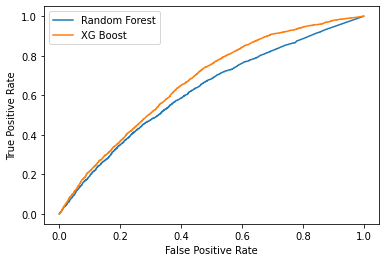

In [263]:
'''T9. Plot ROC-curve.'''

rf = plot_roc_curve(model_bag, X_val, y_val, label='Random Forest')
xgb = plot_roc_curve(model_boost, X_val, y_val, ax=rf.ax_, label='XG Boost')
plt.legend()

**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`. 

In [264]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report


model_cr = classification_report(y_val, model_boost.predict(X_val))
print('XG Boost Classifier')
print(model_cr)

XG Boost Classifier
              precision    recall  f1-score   support

           0       0.71      0.96      0.82      7092
           1       0.49      0.10      0.16      2997

    accuracy                           0.70     10089
   macro avg       0.60      0.53      0.49     10089
weighted avg       0.65      0.70      0.62     10089



**Task 10 Testing**

In [265]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [266]:
'''T11. Create DataFrame of permutation importances.'''

perm_imp = permutation_importance(
    model_boost,
    X_val,
    y_val,
    n_jobs=100,
    random_state=42
)

# Put results into a DataFrame
data = {'importances_mean': perm_imp['importances_mean'],
        'importances_std': perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values(by='importances_mean', inplace=True)


data = {'importances_mean': perm_imp['importances_mean'],
        'importances_std': perm_imp['importances_std']}

permutation_importances = pd.DataFrame(data, index=X_val.columns)
permutation_importances.sort_values(by='importances_mean', inplace = True)

permutation_importances.shape
permutation_importances

,importances_mean,importances_std
City,-0.000139,0.000079
Risk,0.000793,0.000904
Zip,0.003073,0.001198
Facility Type,0.004143,0.001146
Longitude,0.005551,0.001736
Latitude,0.007136,0.002843
Inspection Type,0.011954,0.001456


**Task 11 Testing**

In [267]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

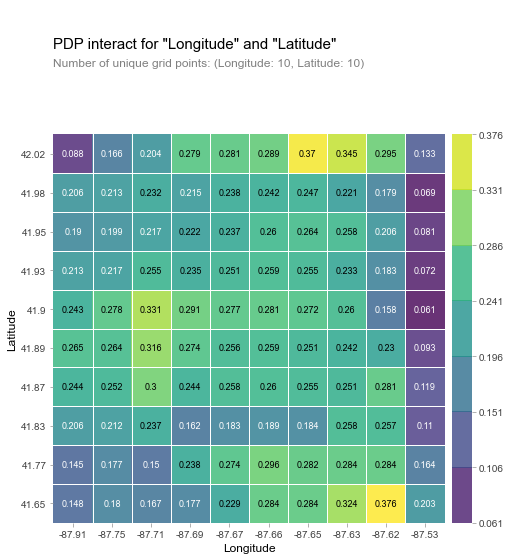

In [272]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''
features = ['Longitude', 'Latitude']

interact = pdp_interact(
    model=model_boost,
    dataset=X_val.dropna(),
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

What do you think? Is there a relationship between location and failing a food saftey inspection?